# Comparing two procedures to find partitions:


## Setup: 

- Reading the problem instance;
- Generating two individuals;

In [1]:
from os import path
from pprint import pprint
from ga4stpg.graph.reader import ReaderORLibrary

instance_problem = "steinb5.txt"
folder_datasets = path.join('..', '..', 'ppgi-stpg-gpx', 'datasets', 'ORLibrary')
filename = path.join(folder_datasets, instance_problem)

STPG = ReaderORLibrary().parser(filename)

def f_weight(x, y):
    return STPG.graph.weight(x,y)

In [2]:
print("STPG information", '\n', 10*'- ','\n')
print('Instance: ', STPG.name)
print("Nro. Node:", STPG.nro_nodes)
print("Nro. Edges:", STPG.nro_edges)
print("Nro. Terminals:", STPG.nro_terminals)
print("Terminals: \n", STPG.terminals)

STPG information 
 - - - - - - - - - -  

Instance:  B5
Nro. Node: 50
Nro. Edges: 100
Nro. Terminals: 13
Terminals: 
 {3, 35, 5, 37, 7, 39, 13, 15, 16, 20, 23, 24, 31}


In [3]:
from ga4stpg.graph.util import is_steiner_tree
from ga4stpg.tree.evaluation import EvaluateTreeGraph
from ga4stpg.tree.generate import GenerateBasedRandomWalk
from ga4stpg.tree.mutate import Prunning

generator = GenerateBasedRandomWalk(STPG)
evaluator = EvaluateTreeGraph(STPG)
prunning  = Prunning(STPG)

red  = generator()
blue = generator()

print(evaluator(red))
print(evaluator(blue))

(246, 1)
(243, 1)


In [4]:
red = prunning(red)
blue = prunning(blue)

print(evaluator(red))
print(evaluator(blue))

(141, 1)
(118, 1)


In [5]:
is_steiner_tree(red, STPG)

(True,
 {'has_cycle': False,
  'all_terminals_in': True,
  'all_leaves_are_terminals': True,
  'all_edges_are_reliable': True,
  'graph_is_connected': True})

In [6]:
is_steiner_tree(blue, STPG)

(True,
 {'has_cycle': False,
  'all_terminals_in': True,
  'all_leaves_are_terminals': True,
  'all_edges_are_reliable': True,
  'graph_is_connected': True})

## Find components in Partition Crossover

In [7]:
from collections import deque
from operator import attrgetter
from random import choice

from ga4stpg.graph import UGraph
from ga4stpg.graph.disjointsets import DisjointSets

In [8]:
class Component:

    def __init__(self, first, second, initialcost=0):
        self.edges = {first : None, second : first}
        self.portal = set()
        self.cost = initialcost

    def add(self, first, second):
        self.edges[second] = first

    def __contains__(self, value):
        return value in self.edges

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        return f"Component <{self.portal}>"

In [9]:
def compose(red : UGraph, blue : UGraph):
    '''
    Parameters:
    ----------
        red, blue : Graph

    Return:
    -------
        g_union, g_common, g_star : Graph
    '''

    g_union  = UGraph()
    g_common = UGraph()
    g_star   = UGraph()

    for v, u in red.gen_undirect_edges():
        g_union.add_edge(v, u)
        if not blue.has_edge(v,u):
            g_star.add_edge(v,u)

    for v, u in blue.gen_undirect_edges():
        g_union.add_edge(v, u)
        if red.has_edge(v,u):
            g_common.add_edge(v, u)
        else:
            g_star.add_edge(v,u)


    return g_union, g_common, g_star

In [10]:
# def connected(self, g_union : UGraph, red : UGraph, blue : UGraph, start : 'node'):
def find_components( g_union : UGraph, red : UGraph, blue : UGraph, start : 'node', f_weight):

        linkedlist = deque([start])
        visited = set()
        parents = DisjointSets()
        # f_weight = f_weight

        for v in g_union.vertices:
            parents.make_set(v)

        def chase(main, node, component):

            if (node in red) and (node in blue):
                if node not in visited and node not in linkedlist:
                    linkedlist.appendleft(node)

                component.portal.add(node)
                return

            for w in main.adjacent_to(node):
                if w in component.edges:
                    continue
                component.add(node, w)
                component.cost += f_weight(node, w)
                chase(main, w, component)
            # end for loop
            visited.add(node)

        components_red  = list()
        components_blue = list()

        while linkedlist:
            u = linkedlist.pop()
            visited.add(u)
            for v in g_union.adjacent_to(u):
                if v in visited:
                    continue
                if red.has_edge(u,v) and blue.has_edge(u,v):
                    linkedlist.append(v)
                    parents.union(u, v)

                elif red.has_edge(u,v):
                    component = Component(u, v, initialcost=f_weight(u,v))
                    chase(red, v, component)
                    chase(red, u, component)
                    components_red.append(component)

                elif blue.has_edge(u,v):
                    component = Component(u, v, initialcost=f_weight(u,v))
                    chase(blue, v, component)
                    chase(blue, u, component)
                    components_blue.append(component)
            # end for loop
        # end while loop
        return components_red, components_blue, parents

## Find Segments' procedure

In [11]:
from ga4stpg.edgeset import UEdge, EdgeSet

class Segment:

    def __init__(self):
        self.edges = EdgeSet()
        self.cost = 0
        self.portals = set()

    def __len__(self):
        return len(self.edges)

    def __str__(self):
        return f'Segment <{self.portals}>'
    
    def __repr__(self):
        return self.__str__()

    def __iter__(self):
        return iter(self.edges)

    @property
    def bounds(self):
        return frozenset(self.portals)
    
    def add(self, v, u):
        self.edges.add(UEdge(v, u))

In [12]:
from random import randrange

def f_weight(v, u):
    if STPG.graph.has_edge(v, u):
        return STPG.graph.weight(v, u)
    else:
        return 0

def find_segments(graph, common_nodes):
    visited = set()

    # start = None
    # index = randrange(0, len(common_nodes))
    # for i, nro in enumerate(common_nodes):
    #     if i == index:
    #         start = nro
    #         break 
    # assert start is not None
    # stack_outter = [start]
    stack_outter = list(common_nodes)
    result = list()

    def search(start, neighbor):
        segment = Segment()
        segment.portals.add(start)
        segment.add(start, neighbor)
        segment.cost += f_weight(start, neighbor)
        
        stack_inner = [neighbor]

        while stack_inner:
            u = stack_inner.pop()
            visited.add(u)
            if u not in common_nodes:
                counter = 0
                for w in graph.adjacent_to(u):
                    if w not in visited:
                        stack_inner.append(w)
                        segment.add(u, w)
                        segment.cost += f_weight(u, w)
                        counter += 1
                if counter == 0:
                    segment.portals.add(u)                    
            else:
                stack_outter.append(u)
                segment.portals.add(u)
        # end while
        return segment
        # end search

    while stack_outter:
        s = stack_outter.pop()
        
        visited.add(s)
        for v in graph.adjacent_to(s):
            if v not in visited:
                seg = search(s, v)
                result.append(seg)

    return result

## Finding components

In [13]:
g_union, g_common, g_star = compose(red, blue)

start = choice(tuple(STPG.terminals))

first, second, group = find_components( g_union, red, blue, start, f_weight)

In [14]:
print(len(first))
print(len(second))

7
10


## Finding Segments

In [15]:
child     = UGraph()
red_only  = UGraph()
blue_only = UGraph()

# - - - - - - - - - - - - - - - - - - - -
for v, u in red.gen_undirect_edges():
    if blue.has_edge(v, u):
        child.add_edge(v, u)
    else:
        red_only.add_edge(v, u)

# - - - - - - - - - - - - - - - - - - - -
for v, u in blue.gen_undirect_edges():
    if not red.has_edge(v, u):
        blue_only.add_edge(v, u)

common_nodes = set(red.vertices) & set(blue.vertices)
len(common_nodes)

21

In [16]:
common_nodes_red = set(red_only.vertices) & set(blue.vertices)

common_nodes_red

{3, 4, 5, 7, 12, 16, 20, 21, 23, 25, 31, 37, 39, 48, 49}

In [17]:
common_nodes_blue = set(blue_only.vertices) & set(red.vertices)

common_nodes_blue

{3, 4, 5, 7, 12, 16, 21, 23, 25, 26, 37, 39, 48, 49}

In [18]:
red_segments  = find_segments(red_only, common_nodes_red)
blue_segments = find_segments(blue_only, common_nodes_blue)

In [19]:
print(len(red_segments))
print(len(blue_segments))

7
9


In [20]:

print("O número de componentes é igual ao número de segmentos encontrados?")
print(len(red_segments) == len(first))
print(len(blue_segments) == len(second))

O número de componentes é igual ao número de segmentos encontrados?
True
False


In [21]:
# As arestas e vértices de g_common e child são iguais

print("G_common e child possuem o mesmo conjunto de vértices?", end=' ')
print(set(g_common.vertices) == set(child.vertices))

gcommon_edges = set()
for edge in g_common.gen_undirect_edges():
    gcommon_edges.add((min(edge), max(edge)))

child_edges = set()
for edge in child.gen_undirect_edges():
    child_edges.add((min(edge), max(edge)))

print("G_common e child possuem o mesmo conjunto de arestas?", end=' ')
print(gcommon_edges == child_edges)

G_common e child possuem o mesmo conjunto de vértices? True
G_common e child possuem o mesmo conjunto de arestas? True


In [22]:

_nodes = set()
for v in red_only.vertices:
    _nodes.add(v)
for v in blue_only.vertices:
    _nodes.add(v)

gstar_vertices = set(g_star.vertices)

print("Os vértices presentes em red_only e blue_only são os mesmos presentes em gstar_vertices?")
print(gstar_vertices == _nodes)

Os vértices presentes em red_only e blue_only são os mesmos presentes em gstar_vertices?
True


In [23]:
# A variável common_nodes guarda os vértices que são comuns aos subgrafos formados pelas arestas presentes em apenas um dos pais.
# Os vertices de common_nodes são os mesmos que os vértices em 'G_STAR' ?

common_gstar = set(v for v in g_star.vertices if (red.has_node(v) and blue.has_node(v)))

print("Os vertices de common_nodes são os mesmos que os vértices em 'G_STAR'?")
print(common_gstar == common_nodes)

print("\nQuais vértices aparecem em common_gstar que não aparecem em common_nodes")
diffset = common_gstar - common_nodes

print(diffset)

gcommon_vertices = set(g_common.vertices)
print("\nEsses vértices estão presentes em g_common?")
print(diffset.issubset(gcommon_vertices))

Os vertices de common_nodes são os mesmos que os vértices em 'G_STAR'?
False

Quais vértices aparecem em common_gstar que não aparecem em common_nodes
set()

Esses vértices estão presentes em g_common?
True


In [24]:
print("Todos os vértices portais de 'first' são vértices comuns?")
all(red.has_node(p) and blue.has_node(p) 
    for component in first
        for p in component.portal)

Todos os vértices portais de 'first' são vértices comuns?


True

In [25]:
print("Todos os vértices portais de second são vértices comuns?")
all(red.has_node(p) and blue.has_node(p) 
    for component in second
        for p in component.portal)

Todos os vértices portais de second são vértices comuns?


True

In [26]:
print("Todos os vértices portais de red_segments são vértices comuns? ")
all(red.has_node(p) and blue.has_node(p)
        for seg in red_segments
            for p in seg.portals)

Todos os vértices portais de red_segments são vértices comuns? 


True

In [27]:
print("Todos os vértices portais de blue_segments são vértices comuns? ")
all(red.has_node(p) and blue.has_node(p)
        for seg in blue_segments
            for p in seg.portals)

Todos os vértices portais de blue_segments são vértices comuns? 


True

In [28]:
print("Os vértices portais de red_segments estão contidos dentro do conjunto common_nodes?")
redseg_portais = set(p for seg in red_segments for p in seg.portals )
print(redseg_portais.issubset(common_nodes))

print("\nOs vértices portais de red_segments estão contidos dentro do conjunto common_star?")
print(redseg_portais.issubset(common_gstar))

Os vértices portais de red_segments estão contidos dentro do conjunto common_nodes?
True

Os vértices portais de red_segments estão contidos dentro do conjunto common_star?
True


In [29]:
print("Os vértices portais de blue_segments estão contidos dentro do conjunto common_nodes?")
blueseg_portais = set(p for seg in blue_segments for p in seg.portals )
print(blueseg_portais.issubset(common_nodes))

print("\nOs vértices portais de blue_segments estão contidos dentro do conjunto common_star?")
print(blueseg_portais.issubset(common_gstar))

Os vértices portais de blue_segments estão contidos dentro do conjunto common_nodes?
True

Os vértices portais de blue_segments estão contidos dentro do conjunto common_star?
True


'common_nodes' não consideram aqueles vértices que são comuns entre o subgrafo formado pelas arestas comuns (g_common) e os subgrafos red_only ou blue_only. Esses eram os vértices considerados como portais.

Apesar disso, os vértices portais de cada segmento considera esses vértices.


In [30]:
# O conjunto de vértices portais dos componentes e dos segumentos são os mesmos?
portais_first = set(p for component in first for p in component.portal)
portais_second = set(p for component in second for p in component.portal)

portais_redseg = set(p for segmento in red_segments for p in segmento.portals)
portais_blueseg = set(p for segmento in blue_segments for p in segmento.portals)

print("O conjunto de vértices portais dos componentes e dos segumentos são os mesmos?")
print(portais_first == portais_redseg)

if not (portais_first == portais_redseg):
    print("\t", portais_first - portais_redseg)
    print("\t",portais_redseg - portais_first)

print(portais_second == portais_blueseg)
if not (portais_second == portais_blueseg):
    print("\t", portais_second - portais_blueseg)
    print("\t", portais_blueseg - portais_second)

O conjunto de vértices portais dos componentes e dos segumentos são os mesmos?
True
True


In [31]:
# O conjunto de arestas dos componentes e dos segmentos são os mesmos?

def get_edges_from_component(component):
    edges = EdgeSet()
    for v, u in component.edges.items():
        if u is not None:
            edges.add(v, u)

    return edges

edgesfirst = list()
for component in first:
    edges = get_edges_from_component(component)
    edgesfirst.extend(edges)

edgessecond = list()
for component in second:
    edges = get_edges_from_component(component)
    edgessecond.extend(edges)

len(edgesfirst), len(edgessecond)

(19, 15)

In [32]:
redseg_edges = [edge for seg in red_segments for edge in seg.edges]
blueseg_edges = [edge for seg in blue_segments for edge in seg.edges]

len(redseg_edges), len(blueseg_edges)

(19, 14)

In [33]:
set(edgesfirst) == set(redseg_edges)

True

In [34]:
set(edgessecond) == set(blueseg_edges)

True

As arestas não comuns encontradas pelos dois procedimentos são iguais. No entanto elas estão distribuídas de forma diferente entre as partições.

In [35]:
for seg in red_segments:
    print(seg,end="\n\t")
    for edge in seg.edges:
        print(edge,end=" ")
    print("\n\n")

Segment <{23, 31}>
	Edge <(23, 31)> 


Segment <{25, 5}>
	Edge <(5, 25)> 


Segment <{48, 21}>
	Edge <(27, 48)> Edge <(17, 21)> Edge <(17, 27)> 


Segment <{16, 4, 20, 12}>
	Edge <(2, 16)> Edge <(2, 12)> Edge <(2, 47)> Edge <(20, 47)> Edge <(2, 4)> 


Segment <{20, 39}>
	Edge <(20, 39)> 


Segment <{49, 37, 7}>
	Edge <(7, 46)> Edge <(38, 46)> Edge <(36, 46)> Edge <(38, 49)> Edge <(8, 37)> Edge <(8, 36)> 


Segment <{3, 37}>
	Edge <(3, 34)> Edge <(34, 37)> 




In [36]:
for component in first:
    print(component,end="\n\t")
    edges = get_edges_from_component(component)
    for edge in edges:
        print(edge,end=" ")
    print("\n\n")

Component <{49, 37, 7}>
	Edge <(7, 46)> Edge <(36, 46)> Edge <(8, 36)> Edge <(38, 49)> Edge <(8, 37)> Edge <(38, 46)> 


Component <{3, 37}>
	Edge <(3, 34)> Edge <(34, 37)> 


Component <{25, 5}>
	Edge <(5, 25)> 


Component <{48, 21}>
	Edge <(27, 48)> Edge <(17, 21)> Edge <(17, 27)> 


Component <{16, 20, 4, 12}>
	Edge <(2, 16)> Edge <(2, 12)> Edge <(2, 47)> Edge <(20, 47)> Edge <(2, 4)> 


Component <{20, 39}>
	Edge <(20, 39)> 


Component <{31, 23}>
	Edge <(23, 31)> 




In [37]:
for seg in blue_segments:
    print(seg,end="\n\t")
    for edge in seg.edges:
        print(edge,end=" ")
    print("\n\n")

Segment <{26, 12}>
	Edge <(6, 12)> Edge <(6, 26)> 


Segment <{48, 25}>
	Edge <(25, 48)> 


Segment <{48, 5}>
	Edge <(5, 48)> 


Segment <{21, 5, 7}>
	Edge <(1, 18)> Edge <(1, 21)> Edge <(5, 18)> Edge <(1, 7)> 


Segment <{16, 21}>
	Edge <(16, 21)> 


Segment <{37, 21}>
	Edge <(21, 37)> 


Segment <{16, 23}>
	Edge <(16, 42)> Edge <(23, 42)> 


Segment <{49, 4}>
	Edge <(4, 49)> 


Segment <{3, 39}>
	Edge <(3, 39)> 




In [38]:
for component in second:
    print(component,end="\n\t")
    edges = get_edges_from_component(component)
    for edge in edges:
        print(edge,end=" ")
    print("\n\n")

Component <{37, 21}>
	Edge <(21, 37)> 


Component <{49, 4}>
	Edge <(4, 49)> 


Component <{48, 5}>
	Edge <(5, 48)> 


Component <{5, 21, 7}>
	Edge <(1, 18)> Edge <(1, 21)> Edge <(5, 18)> Edge <(1, 7)> 


Component <{3, 39}>
	Edge <(3, 39)> 


Component <{16, 21}>
	Edge <(16, 21)> 


Component <{16, 21}>
	Edge <(16, 21)> 


Component <{48, 25}>
	Edge <(25, 48)> 


Component <{26, 12}>
	Edge <(6, 12)> Edge <(6, 26)> 


Component <{16, 23}>
	Edge <(16, 42)> Edge <(23, 42)> 




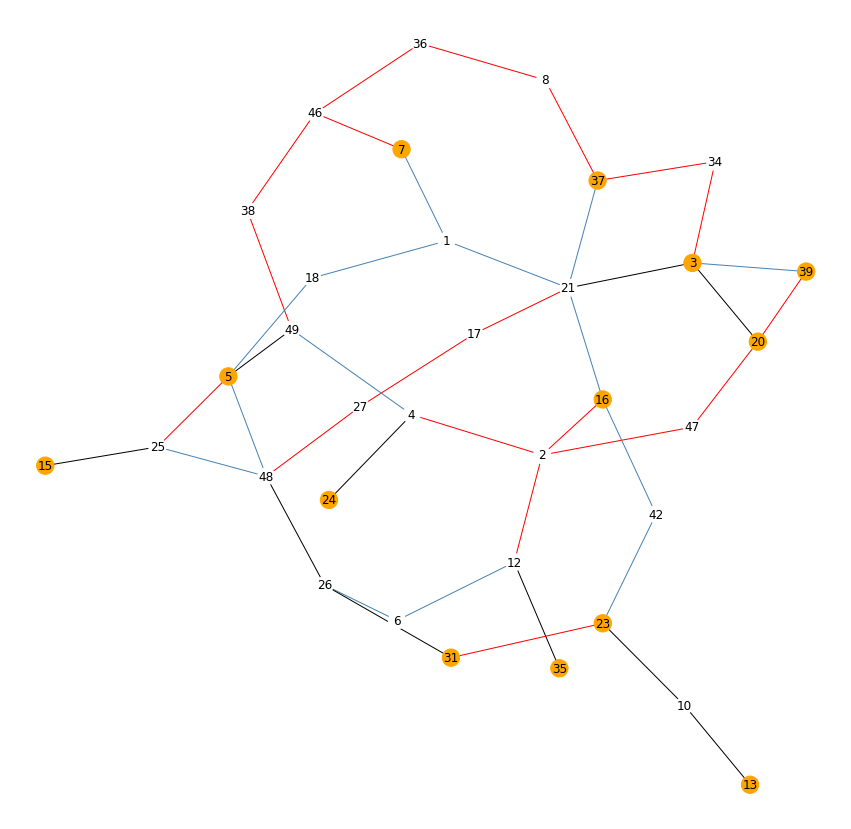

In [39]:
from draw import draw_common
from matplotlib import pyplot as plt

plt.figure(figsize=(15,15))

draw_common(g_union, STPG.terminals, red, blue)

## Porque esses dois procedimentos encontram números diferentes de partições?

Depois de observar atentamente, percebi que o procedimento para encontrar os componentes (```find_components```) repete uma componente a mais do que o procedimento denominado para encontrar segmentos (```find_segments```).

Por ora vou considerar que o procedimento para encontrar partições (ou segmentos) está concluído, embora possam ser pensadas outras melhorias para esse procedimento.